In [1]:
import pandas
import datetime
import numpy
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap
from matplotlib import ticker
%matplotlib inline
from matplotlib import rcParams

In [2]:
#### In this block we load Velocity data ####
#### In this block we load Velocity data ####
#### In this block we load Velocity data ####
# file with velocities
rawVelFileName = "../data/test-vels-north.txt"
# need to format the file appropritely, before we can read it
outFormattedFile = "../data/formatted-vels.txt"
# os.system( 'cat ' + rawVelFileName + ' | tr -s "  " > ' + outFormattedFile )
inpColNames = [ "dateStr", "timeStr", "beam", "range", \
          "azim", "Vlos", "MLAT", "MLON", "MLT", "radId", \
          "radCode"]
velsDataDF = pandas.read_csv(outFormattedFile, sep=' ',\
                             header=None, names=inpColNames)
# add a datetime col
velsDataDF["date"] = pandas.to_datetime( \
                        velsDataDF['dateStr'].astype(str) + "-" +\
                        velsDataDF['timeStr'].astype(str), format='%Y%m%d-%H%M')
# for some reason MLAT is a str type, convert it to float
velsDataDF["MLAT"] = velsDataDF["MLAT"].astype(float)
# Also get a normMLT for plotting
velsDataDF['normMLT'] = [x-24 if x >= 12 else x for x in velsDataDF['MLT']]
velsDataDF.head()
#### In this block we load SAPS Velocity data ####
#### In this block we load SAPS Velocity data ####
#### In this block we load SAPS Velocity data ####

,dateStr,timeStr,beam,range,azim,Vlos,MLAT,MLON,MLT,radId,radCode,date,normMLT
0,20110409,600,0,26,-60.95,-2.2716,53.2044,-21.8611,23.6993,33,bks,2011-04-09 06:00:00,-0.3007
1,20110409,600,0,27,-60.95,-5.1056,53.3065,-22.5771,23.6515,33,bks,2011-04-09 06:00:00,-0.3485
2,20110409,600,0,28,-60.95,-5.1056,53.4035,-23.2954,23.6036,33,bks,2011-04-09 06:00:00,-0.3964
3,20110409,600,0,29,-60.95,-4.5666,53.4954,-24.0159,23.5556,33,bks,2011-04-09 06:00:00,-0.4444
4,20110409,600,0,30,-60.95,-3.6944,53.5823,-24.7384,23.5074,33,bks,2011-04-09 06:00:00,-0.4926


In [3]:
#### In this block we filter for SAPS velocities ####
#### In this block we filter for SAPS velocities ####
#### In this block we filter for SAPS velocities ####
# remove velocies whose magnitude is less than 200 m/s
velsDataDF = velsDataDF[ abs(velsDataDF["Vlos"]) >= 200. ]
# SAPS(westward) Vlos are positive for positive azimuths and vice versa.
# filter the others out
velsDataDF = velsDataDF[ velsDataDF["azim"]/velsDataDF["Vlos"] > 0. ].reset_index(drop=True)
velsDataDF.head()
#### In this block we filter for SAPS velocities ####
#### In this block we filter for SAPS velocities ####
#### In this block we filter for SAPS velocities ####

,dateStr,timeStr,beam,range,azim,Vlos,MLAT,MLON,MLT,radId,radCode,date,normMLT
0,20110409,706,9,28,-26.21,-244.3651,59.1492,-14.0168,1.3205,33,bks,2011-04-09 07:06:00,1.3205
1,20110409,706,10,28,-22.35,-244.3651,59.5371,-12.4132,1.4274,33,bks,2011-04-09 07:06:00,1.4274
2,20110409,708,9,27,-26.21,-226.6634,58.8263,-13.5483,1.3848,33,bks,2011-04-09 07:08:00,1.3848
3,20110409,708,10,27,-22.35,-226.6634,59.1965,-12.0037,1.4878,33,bks,2011-04-09 07:08:00,1.4878
4,20110409,730,8,27,-30.07,-257.8685,58.3937,-14.9997,1.6560,33,bks,2011-04-09 07:30:00,1.6560


In [4]:
#### Need prev SAPS data to determine SAPS scatter ####
#### Need prev SAPS data to determine SAPS scatter ####
#### Need prev SAPS data to determine SAPS scatter ####
datFileName = "../data/processedSaps.txt"
sapsDataDF = pandas.read_csv(datFileName, sep=' ', dtype={'dateStr':'str', 'time': 'str'})

sapsDataDF["date"] = pandas.to_datetime( \
                        sapsDataDF['dateStr'] + "-" +\
                        sapsDataDF['time'], format='%Y%m%d-%H%M')
sapsDataDF.head()
#### Need prev SAPS data to determine SAPS scatter ####
#### Need prev SAPS data to determine SAPS scatter ####
#### Need prev SAPS data to determine SAPS scatter ####

,dateStr,sapsLat,sapsMLT,sapsVel,radId,poesLat,poesMLT,dst_date,dst_index,time,date
0,20110107,56.5,17.7543,308.2077,33,62.0082,18,2011-01-07 00:00:00,-18,0000,2011-01-07
1,20110107,55.5,18.0147,224.1588,33,62.0082,18,2011-01-07 00:00:00,-18,0000,2011-01-07
2,20110107,56.5,17.8749,307.4328,33,62.0082,18,2011-01-07 00:00:00,-18,0000,2011-01-07
3,20110107,55.5,18.1324,222.4787,33,62.0082,18,2011-01-07 00:00:00,-18,0000,2011-01-07
4,20110107,56.5,17.9955,305.4201,33,62.0082,18,2011-01-07 00:00:00,-18,0000,2011-01-07


In [5]:
#### Choose a time to and get POES boundaries as well ####
#### Choose a time to and get POES boundaries as well ####
#### Choose a time to and get POES boundaries as well ####
# we choose 0840 UT since that time was analyzed in the paper
timeSlctd = datetime.datetime( 2011, 4, 9, 8, 40 )
velAnlysDF = velsDataDF[ velsDataDF["date"] == timeSlctd ].reset_index(drop=True)
sapsSelPrdDF = sapsDataDF[  ( sapsDataDF["date"] - timeSlctd < numpy.timedelta64(30,'m') )\
           & ( sapsDataDF["date"] - timeSlctd > numpy.timedelta64(0,'m') )  ].reset_index(drop=True)
# Now check if there is more than one time period in the selected interval
# ideally there shouldn't be, but if we find one we should do something
# about it (like take an average)...for now its undecided.!
if len( sapsSelPrdDF["time"].unique() ) > 1:
    print "There is more than one time period selected!!!"
    print "NEED TO CHECK SOMETHING WRONG!!!"
    print "NEED TO CHECK SOMETHING WRONG!!!"
    print "NEED TO CHECK SOMETHING WRONG!!!"
poesBndDF = sapsSelPrdDF[ ["poesMLT", "poesLat"] \
                    ].drop_duplicates().reset_index(drop=True)
# Have a normalized MLT for ease of comparison
poesBndDF['normMLT'] = [x-24 if x >= 12 else x for x in poesBndDF['poesMLT']]
poesBndDF.head()
#### Choose a time to and get POES boundaries as well ####
#### Choose a time to and get POES boundaries as well ####
#### Choose a time to and get POES boundaries as well ####

,poesMLT,poesLat,normMLT
0,0,62.0360,0
1,1,61.5064,1
2,2,61.2108,2
3,3,61.1692,3
4,23,62.7634,-1


In [6]:
#### For the chosen time get velocities which fall below POES BND ####
#### For the chosen time get velocities which fall below POES BND ####
#### For the chosen time get velocities which fall below POES BND ####
# Merge POES boundary DF with the vels DF
velAnlysDF["normMLTRound"] = velAnlysDF["normMLT"].astype(int)
print "shape before join--->", velAnlysDF.shape
velAnlysDF = pandas.merge( velAnlysDF, poesBndDF, left_on="normMLTRound", right_on="normMLT", how="inner" )
print "shape after join--->", velAnlysDF.shape
# Filter out velocties above the POES boundary
velAnlysDF = velAnlysDF[ velAnlysDF["MLAT"] < velAnlysDF["poesLat"]\
                       ].reset_index(drop=True).drop_duplicates()
print "shape after filtering by boundary--->", velAnlysDF.shape
#### For the chosen time get velocities which fall below POES BND ####
#### For the chosen time get velocities which fall below POES BND ####
#### For the chosen time get velocities which fall below POES BND ####

shape before join---> (204, 14)
shape after join---> (195, 17)
shape after filtering by boundary---> (195, 17)


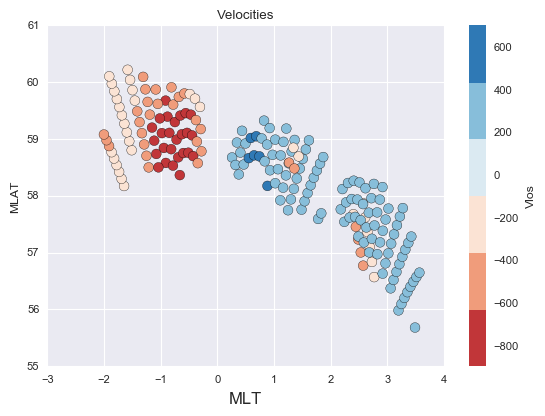

In [7]:
#### Plot the chosen SAPS velocities ####
#### Plot the chosen SAPS velocities ####
#### Plot the chosen SAPS velocities ####
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("RdBu"))
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
velAnlysDF.plot( kind='scatter',
              x='normMLT_x',
              y='MLAT',
              c='Vlos',
              s=50., cmap=seaMap, ax=ax)
ax.set_ylabel("MLAT")
ax.set_xlabel("MLT", fontsize=12)
ax.set_title( "Velocities" )
# ax.set_ylim( [55., 62.] )

ax.get_figure().savefig("../figs/sapsVels.pdf",bbox_inches='tight')
#### Plot the chosen SAPS velocities ####
#### Plot the chosen SAPS velocities ####
#### Plot the chosen SAPS velocities ####

In [8]:
#### Divide the velocities into a MLT-MLAT grid ####
#### Divide the velocities into a MLT-MLAT grid ####
#### Divide the velocities into a MLT-MLAT grid ####
# Select only required columns/ discard unwanted cols
# velAnlysDF["grid_MLT"] = [ round(x*2)/2 for x in velAnlysDF['normMLT_x'] ]
velAnlysDF["grid_MLT"] = [ round(x) for x in velAnlysDF['normMLT_x'] ]
velAnlysDF["grid_MLAT"] = [ round(x*2)/2 for x in velAnlysDF['MLAT'] ]
velAnlysDF = velAnlysDF[ [ "beam", "range", "azim", "Vlos", "MLAT", \
                          "MLT", "grid_MLT", "grid_MLAT", "radId", \
                          "radCode", "normMLT_x" ] ]
velAnlysDF.head()
#### Divide the velocities into a MLT-MLAT grid ####
#### Divide the velocities into a MLT-MLAT grid ####
#### Divide the velocities into a MLT-MLAT grid ####

,beam,range,azim,Vlos,MLAT,MLT,grid_MLT,grid_MLAT,radId,radCode,normMLT_x
0,5,27,-41.65,-378.1679,56.7707,2.5742,3,57.0,33,bks,2.5742
1,5,28,-41.65,-396.3842,57.0027,2.5315,3,57.0,33,bks,2.5315
2,5,29,-41.65,-379.2044,57.2309,2.4884,2,57.0,33,bks,2.4884
3,5,30,-41.65,-368.0763,57.4553,2.4448,2,57.5,33,bks,2.4448
4,5,31,-41.65,-321.3911,57.6758,2.4007,2,57.5,33,bks,2.4007


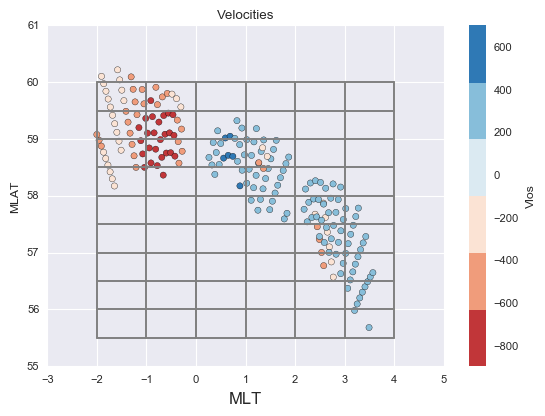

In [9]:
# print velAnlysDF[ velAnlysDF["radCode"] == "cve" ]#.plot( x="azim", y="Vlos", kind="scatter" )
#### Plot the chosen SAPS velocities ####
#### Plot the chosen SAPS velocities ####
#### Plot the chosen SAPS velocities ####
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("RdBu"))
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
plotMLTs = velAnlysDF['grid_MLT'].unique().tolist()
plotMLATs = velAnlysDF['grid_MLAT'].unique().tolist()
for currMLT in plotMLTs :
    ax.plot( [currMLT, currMLT], [ min(plotMLATs), max(plotMLATs) ], '0.5' )
ax.plot( [0., 0.], [ min(plotMLATs), max(plotMLATs) ], '0.5' )
for currMLAT in plotMLATs :
    ax.plot( [ min(plotMLTs), max(plotMLTs) ], [currMLAT, currMLAT], '0.5' )
velAnlysDF.plot( kind='scatter',
              x='normMLT_x',
              y='MLAT',
              c='Vlos',
              s=20., cmap=seaMap, ax=ax)
ax.set_ylabel("MLAT")
ax.set_xlabel("MLT", fontsize=12)
ax.set_title( "Velocities" )
ax.set_ylim( [int(round(velAnlysDF['grid_MLAT'].min()))-1, \
              int(round(velAnlysDF['grid_MLAT'].max()))+1] )
ax.set_xlim( [int(round(velAnlysDF['grid_MLT'].min()))-1, \
              int(round(velAnlysDF['grid_MLT'].max()))+1] )

ax.get_figure().savefig("../figs/sapsVels-grid.pdf",bbox_inches='tight')
#### Plot the chosen SAPS velocities ####
#### Plot the chosen SAPS velocities ####
#### Plot the chosen SAPS velocities ####

In [19]:
print velAnlysDF[ (velAnlysDF["MLT"] < 3.) &\
                 (velAnlysDF["MLT"] > 2.) &\
                (velAnlysDF["MLAT"] < 58.) &\
                (velAnlysDF["MLAT"] > 57.5)]#.plot(x="azim",y="Vlos", kind="scatter")
# print velAnlysDF[velAnlysDF["radCode"] == "bks"]

    beam  range   azim      Vlos     MLAT     MLT  grid_MLT  grid_MLAT  radId  \
4      5     31 -41.65 -321.3911  57.6758  2.4007         2       57.5     33   
9      6     28 -37.79 -356.0613  57.6176  2.6087         3       57.5     33   
10     6     29 -37.79 -325.0995  57.8713  2.5678         3       58.0     33   
11     5     20  27.18  207.5621  57.7620  2.1786         2       58.0    205   
13     6     20  30.42  223.1375  57.5416  2.2411         2       57.5    205   
14     6     21  30.42  223.6005  57.8848  2.2733         2       58.0    205   
16     7     21  33.66  275.3992  57.6178  2.3355         2       57.5    205   
17     7     22  33.66  249.4025  57.9430  2.3710         2       58.0    205   
19     8     22  36.90  306.7734  57.6283  2.4323         2       57.5    205   
20     8     23  36.90  258.0663  57.9335  2.4709         2       58.0    205   
23     9     23  40.14  304.8513  57.5705  2.5306         3       57.5    205   
24     9     24  40.14  267.

/usr/local/lib/python2.7/site-packages/pandas/tools/plotting.py:2625: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  warnings.warn(msg, FutureWarning)


{'boxes': [<matplotlib.lines.Line2D at 0x110249c90>],
 'caps': [<matplotlib.lines.Line2D at 0x110257a90>,
 'fliers': [<matplotlib.lines.Line2D at 0x110264d90>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x110264750>],
 'whiskers': [<matplotlib.lines.Line2D at 0x110249e50>,
  <matplotlib.lines.Line2D at 0x110249950>]}

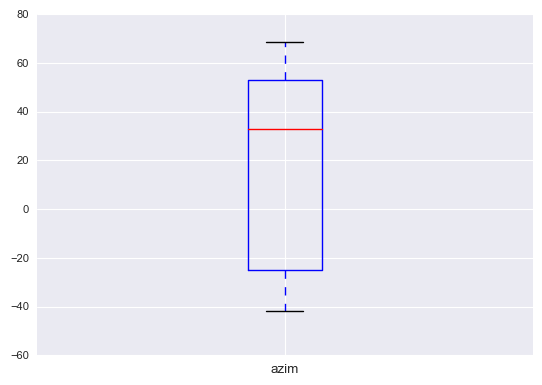

In [11]:
# velAnlysDF[ (velAnlysDF["grid_MLT"] == 0) & (velAnlysDF["grid_MLAT"] == 59.5) ].plot(x="azim",y="Vlos", kind="scatter")
velAnlysDF.boxplot(column="azim")
# print velAnlysDF[ (velAnlysDF["grid_MLT"] == 0) & (velAnlysDF["grid_MLAT"] == 59.5) ]["azim"].describe()

In [12]:
print velAnlysDF["azim"].describe()

count    195.000000
mean      16.117590
std       39.431959
min      -41.650000
25%      -24.860000
50%       32.940000
75%       53.100000
max       68.580000
Name: azim, dtype: float64
